# Importing Dependencies and Defining Paths

In [1]:
from pathlib import Path
from glob import glob
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import mutual_info_classif

ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

TRAIN_DIR       = ROOT / "csv_files" / "train"
TEST_DIR        = ROOT / "csv_files" / "test"

# Aggregator

In [2]:
class Aggregator:
    """ This class handles the aggregration of the columns in depth > 0 columns
    """
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        """Handles the aggregrated new columns for columns which are "P" or "A" type
        
        Args : 
        -df: not aggregrated dataframe (Polars object)
        
        Return:
        - Polars DataFrame: aggregrated new columns
        """
        
        # Select the columns with the P and A suffixes
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        
        # Create a column conatining the max value of the each selected column
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        # Create a column conatining the last value of the each selected column
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        
        # Create a column conatining the maen value of the each selected column
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        """Handles the aggregrated new columns for columns which are "D" type
        
        Args : 
        -df: not aggregrated dataframe (Polars object)
        
        Return:
        - Polars DataFrame: aggregrated new columns
        """
        
        # Select the columns with the D suffix
        cols = [col for col in df.columns if col[-1] in ("D")]
        
        # Select the columns with the 
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        """Handles the aggregrated new columns for columns which are "M" type
        
        Args : 
        -df: not aggregrated dataframe (Polars object)
        
        Return:
        - Polars DataFrame: aggregrated new columns
        """
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        """Handles the aggregrated new columns for columns which are "T" or "L" type
        
        Args : 
        -df: not aggregrated dataframe (Polars object)
        
        Return:
        - Polars DataFrame: aggregrated new columns
        """
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        exprs = []
        for col in cols:
            # Check if the column's dtype is numeric (int or float)
            if df[col].dtype in [pl.datatypes.Float64, pl.datatypes.Int64]:
                exprs.append(pl.max(col).alias(f"max_{col}"))
                exprs.append(pl.last(col).alias(f"last_{col}"))
                exprs.append(pl.mean(col).alias(f"mean_{col}"))
            else:
                exprs.append(pl.max(col).alias(f"max_{col}"))
                exprs.append(pl.last(col).alias(f"last_{col}"))

        return exprs
    
    def count_expr(df):
        """Handles the aggregrated new columns for columns "num_group1" and "num_group2"
        
        Args : 
        -df: not aggregrated dataframe (Polars object)
        
        Return:
        - Polars DataFrame: aggregrated new columns
        """
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        """Aggregrate the entire dataframe
        
        Args : 
        -df: not aggregrated dataframe (Polars object)
        
        Return:
        - Polars DataFrame: aggregrated new columns
        """
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

# Functions Handling Columns with Missing Values and Dominant Values

In [3]:
def drop_columns_with_high_missing_values(df, threshold=50):
    """
    Drop columns with missing values exceeding a given threshold percentage.
    
    Args:
    - df: DataFrame: Input DataFrame
    - threshold: float: Threshold percentage for missing values
    
    Returns:
    - DataFrame: Modified DataFrame with columns dropped
    """
    # Calculate the percentage of missing values for each column
    missing_percentage = (df.isna().sum() / len(df)) * 100

    # Filter columns with missing percentage greater than the threshold
    columns_to_drop = missing_percentage[missing_percentage > threshold].index

    # Drop columns with more than the threshold percentage of missing values
    df_cleaned = df.drop(columns=columns_to_drop)

    # Display information about dropped columns
    print("Columns dropped due to more than {}% missing values:".format(threshold))
    print(columns_to_drop)

    # Display information about the cleaned DataFrame
    print("Shape of cleaned DataFrame:", df_cleaned.shape)

    return df_cleaned


def remove_dominated_columns(df, threshold=0.8):
    """Remove the columns that has higher amount of null values than the given threshold.
    
    Args:
    - df: DataFrame: Input Polars DataFrame
    - threshold: Maximum null value presentage
    
    Returns:
    - DataFrame: Modified Polars DataFrame with columns dropped    
    
    """
    num_rows = len(df)
    dominated_columns = []
    
    for col in df.columns:
        # Skip 'case_id' column
        if col == 'case_id':
            continue
        
        value_counts = df[col].value_counts()
        dominant_value_count = value_counts.max()
        dominant_value_percentage = dominant_value_count / num_rows
        
        if dominant_value_percentage >= threshold:
            dominated_columns.append(col)
    
    df = df.drop(columns=dominated_columns)
    return df

# Imputer

In [4]:
def impute_missing_values(df):
    """
    Impute missing values in categorical columns with mode and numerical columns with mean.
    
    Args:
    - df: DataFrame: Input DataFrame
    
    Returns:
    - DataFrame: DataFrame with missing values handled using imputation
    """
    # Identify categorical and numerical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    numerical_columns = df.select_dtypes(exclude=['object']).columns

    # Impute missing values for categorical columns with the most frequent value (mode)
    for col in categorical_columns:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Impute missing values for numerical columns with the mean
    for col in numerical_columns:
        df[col].fillna(df[col].mean(), inplace=True)

    # Display information about the cleaned DataFrame
    print("Columns with missing values:")
    missing_values_count = df.isna().sum()
    for column, count in missing_values_count.items():
        if count != 0:
            print(f"{column}: {count}")
            
    return df

# Handling Data Types

In [5]:
def handle_data_types(df):
    """Convert the column data types according to thier suffixes and change it back to optimize the memory
    
    Args:
    - df: Input DataFrame (Polars)
    
    Returns:
    - DataFrame: DataFrame (Pandas) with correct and optimised data types 
    """
    
    for col in df.columns:
        
        if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
            df = df.with_columns(pl.col(col).cast(pl.Int64))
        elif col in ["date_decision"] or  col[-1] in ("D",):
            df = df.with_columns(pl.col(col).cast(pl.Date).dt.timestamp())
        elif col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64))
        elif col[-1] in ("M"):
            df = df.with_columns(pl.col(col).cast(pl.Categorical))
        elif df[col].dtype == "string":
            print(col)
            df = df.with_columns(pl.col(col).cast(pl.Categorical))
        # Converting String or objects to category can memory space But when a String or Object column 
        # has null values It does not convert into category type. Threrefore it is best practice to first 
        # impute the null values and then transform the data types
        
    df = df.to_pandas()
        
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
            
    return df
            

# Preparing a DataFrame

In [6]:
def prepare_df(path, depth=None):
    """ Given a csv file, returns a Polars dataframe which is aggregated, columns with high number of missing values and dominant values removed,
    missing values imputed, and data types handled.
    
    Args:
     - path : path of the csv file
     - depth : depth of the given data set
     
    Return:
     - Pandas dataframe
    
    """
    print(f"Path : {path}")
    df = pl.read_csv(path, null_values="a55475b1")
    
    
    # Aggregating the data frame based on the depth
    if depth == 1 :
        aggregrated_df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    elif depth == 2 :
        intermediate_aggregrated_df = df.group_by(["case_id", "num_group1"]).agg(Aggregator.get_exprs(df))
        aggregrated_df = intermediate_aggregrated_df.group_by("case_id").agg(Aggregator.get_exprs(intermediate_aggregrated_df))
        
    else :
        aggregrated_df = df
    
    
    # Removing the columns with high number of missing values
    aggregrated_pandas_df = aggregrated_df.to_pandas()
    missing_val_dropped_df = drop_columns_with_high_missing_values(aggregrated_pandas_df)
    
    # Removing the columns with dominant values
    dominant_val_dropped_df = remove_dominated_columns(missing_val_dropped_df)
    
    # Imputing missing values
    imputed_df = impute_missing_values(dominant_val_dropped_df)
    
    # Handing data types
    imputed_polars_df = pl.from_pandas(imputed_df)
    handled_df = handle_data_types(imputed_polars_df)
    
    
    return handled_df
    

# Getting Information on Categorical Columns

In [7]:
def get_unique_info_for_categorical_cols(df):
    """
      Gets the number of unique values and a list of unique values for each column containing categorical data in a pandas DataFrame.

      Args:
          df (pandas.DataFrame): The pandas DataFrame to analyze.

      Returns:
          categorical_cols : A list of columns containing categorical values
    """
    categorical_cols = []
    
    for col in df.columns:
        if col != "case_id" and (pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col])):
            categorical_cols.append(col)
            
            # Get unique values and count
            unique_values = df[col].unique().tolist()
            n_unique = len(unique_values)

            # Store information in dictionary
            if n_unique < 50:
                print(f"{col} : {n_unique} unique values\n{unique_values}")
            else:
                print(f"{col} : {n_unique} unique values")
                
    return categorical_cols

# Ordinal Encoding Categorical Features

In [8]:
def ordinal_encoder(df, categorical_cols):
    """Encodes the categorical values of a given DataFrame using Ordinal Encoding.
    
        Args:
         - df : DataFrame to be encoded (A Pandas DataFrame)
         - categorical_cols : A list of columns that contains categorical values of the DataFrame
         
        Return:
            Ordinal-encoded DataFrame sorted by "case_id" (Pandas DataFrame)
    
    """
    
    encoder = OrdinalEncoder()
    
    # Encoding categorical features
    for col in categorical_cols:
        df[col] = encoder.fit_transform(df[[col]])
        
    # Sorting the DataFrame by "case_id"
    sorted_df = df.sort_values(by="case_id")
        
    return sorted_df

# Feature Selection by Ridge Regression

In [9]:
def feature_selection_by_ridge(x, y, threshold=0.05):
    """Selects a list of features using Ridge Regression (L2 Regularization)
    
        Args:
         - x : A Pandas DataFrame containing independent variables
         - y : An array containing the values of target variables
         - threshold : The thresold value above which the features are selected (default 0.05)
         
        Return:
            A list containing selected features
    """
    
    # Training a Ridge Regression model to obtain coefficient values
    ridge_model = Ridge(alpha = 1.0)
    ridge_model.fit(x, y)

    selected_features = []

    for i in range(len(x.columns)):
        # Displaying the feature name and corresponding coefficient value
        print(x.columns[i]," - ",rid_cf.coef_[i])
        
        # Selecting features with coefficeint values above the threshold value
        if rid_cf.coef_[i] > threshold:
            selected_features.append(x.columns[i])


    return selected_features


# Feature Selection by Information Gain

In [10]:
def feature_selection_by_information_gain(x, y, threshold):
    """Selects a list of features information gain
    
        Args:
         - x : A Pandas DataFrame containing independent variables
         - y : An array containing the values of target variables
         - threshold : The thresold value above which the features are selected (default 0.05)
         
        Return:
            A list containing selected features
    """
    
    # Calculatinn information gain
    importances = mutual_info_classif(x, y)
    
    
    # Displaying the information gain values in a bar graph
    feat_importances = pd.Series(importances, x.columns)
    feat_importances.plot(kind="barh", color="teal")
    plt.show()
    
    selected_features = []
    
    for i in range(len(x.columns)):
        # Selecting features with values above the threshold value
        if importances[i] > threshold:
            selected_features.append(x.columns[i])
    
    return selected_features

# Obtaining Correlation Matrix and Number of Highly Correlated Features

In [11]:
def corr_matrix(df):
    """Displays the correlation matrix of the features of a given DataFrame and prints the number of highly correlated features
       (|correlation coefficient| > 0.9) for each feature.
    
       Args:
        - df : A Pandas DataFrame
    """
    
    # Obtaining the corrlation matrix
    corr_matrix = df.corr()
    
    # Displying the correlation matrix
    plt.figure(figsize=(20,20))
    sn.heatmap(corr_matrix, annot=True, cbar=True, square=True, fmt='.2f', annot_kws={'size':8}, cmap='Greens')
    plt.show()
    
    # Getting the number of highly-correlated features 
    highly_correlated = {}
    for col in corr_matrix.columns:
        # Exclude correlation with itself (diagonal)
        corr_values = corr_matrix[col].drop(col).abs()
        
        # Count features exceeding the threshold (absolute value)
        highly_correlated[col] = (corr_values > 0.9).sum()
    
    print("Number of highly correlated features: ")
    print(pd.Series(highly_correlated))

# Obtaining Target Column Data

In [12]:
base_df = pd.read_csv(TRAIN_DIR / "train_base.csv")

target_df = base_df[["case_id","target"]]

target_df

,case_id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
1526654,2703450,0
1526655,2703451,0
1526656,2703452,0
1526657,2703453,0


# Matching Given DataFrame with Target DataFrame and Giving X and Y

In [13]:
def match_x_and_target(df, target_df):
    """Given two data frames, combines the DataFrames on 'case_id'
    
       Args:
        - df : a DataFrames (Pandas DataFrames)
        - target_df : a DataFrames (The target values from the base file) (Pandas data frame)
        
       Return:
        - x : a Pandas DataFrame containing independent features ('case_id' dropped)
        - y : The target values for the data in the 'df' DataFrame
    """

    # Join DataFrames based on 'id' column
    merged_df = df.merge(target_df, on='case_id')

    merged_df
    
    y = merged_df["target"]
    x = merged_df.drop(["target", "case_id"], axis=1)
    
    return x, y

# Person_1

In [14]:
person_1_df = prepare_df(TRAIN_DIR/"train_person_1.csv", 1)

Path : /kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_person_1.csv
Columns dropped due to more than 50% missing values:
Index(['max_birthdate_87D', 'max_empl_employedfrom_271D', 'last_birthdate_87D',
       'last_empl_employedfrom_271D', 'mean_birth_259D', 'mean_birthdate_87D',
       'mean_empl_employedfrom_271D', 'max_education_927M',
       'max_empladdr_district_926M', 'max_empladdr_zipcode_114M',
       'last_contaddr_zipcode_807M', 'last_education_927M',
       'last_empladdr_district_926M', 'last_empladdr_zipcode_114M',
       'last_registaddr_zipcode_184M', 'max_childnum_185L',
       'last_childnum_185L', 'mean_childnum_185L',
       'max_empl_employedtotal_800L', 'last_empl_employedtotal_800L',
       'max_empl_industry_691L', 'last_empl_industry_691L',
       'max_familystate_447L', 'last_familystate_447L', 'max_gender_992L',
       'last_gender_992L', 'max_housetype_905L', 'last_housetype_905L',
       'max_housingtype_772L', 'last_housingtype_7

/tmp/ipykernel_18/1874175882.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipykernel_18/1874175882.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipykernel_18/1874175882.py:21: FutureWarning: A

Columns with missing values:


In [15]:
person_1_df.head()

,case_id,max_mainoccupationinc_384A,last_mainoccupationinc_384A,mean_mainoccupationinc_384A,max_birth_259D,last_birth_259D,max_contaddr_district_15M,max_contaddr_zipcode_807M,max_language1_981M,max_registaddr_district_1083M,...,last_persontype_792L,mean_persontype_792L,max_role_1084L,last_role_1084L,last_safeguarantyflag_411L,max_sex_738L,last_sex_738L,last_type_25L,max_num_group1,last_num_group1
0,1434344,40000.0,40000.000000,40000.0,331257600000000,331257600000000,P93_57_167,P170_114_65,P209_127_106,P93_57_167,...,1.000000,1.0,CL,CL,1.0,M,M,PRIMARY_MOBILE,0,0
1,1808467,32000.0,32000.000000,32000.0,291772800000000,291772800000000,P85_130_149,P99_14_63,P10_39_147,P85_130_149,...,1.000000,1.0,CL,CL,1.0,M,M,PRIMARY_MOBILE,0,0
2,131022,70000.0,58945.558594,70000.0,744163200000000,546825600000000,P131_33_167,P161_14_174,P10_39_147,P131_33_167,...,1.664062,3.0,PE,PE,1.0,M,F,PHONE,2,2
3,1298303,36000.0,36000.000000,36000.0,226022400000000,226022400000000,P25_143_180,P118_33_168,P209_127_106,P25_143_180,...,1.000000,1.0,CL,CL,1.0,M,M,PRIMARY_MOBILE,0,0
4,1369612,38000.0,38000.000000,38000.0,-415497600000000,-415497600000000,P80_85_140,P91_68_99,P209_127_106,P80_85_140,...,1.000000,1.0,CL,CL,1.0,M,M,PRIMARY_MOBILE,0,0


In [16]:
person_1_categorical_cols = get_unique_info_for_categorical_cols(person_1_df)

/tmp/ipykernel_18/2024442434.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if col != "case_id" and (pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col])):


max_contaddr_district_15M : 974 unique values
max_contaddr_zipcode_807M : 3529 unique values
max_language1_981M : 2 unique values
['P209_127_106', 'P10_39_147']
max_registaddr_district_1083M : 990 unique values
max_registaddr_zipcode_184M : 3530 unique values
last_contaddr_district_15M : 614 unique values
last_language1_981M : 2 unique values
['P209_127_106', 'P10_39_147']
last_registaddr_district_1083M : 637 unique values
max_incometype_1044T : 9 unique values
['SALARIED_GOVT', 'EMPLOYED', 'PRIVATE_SECTOR_EMPLOYEE', 'RETIRED_PENSIONER', 'HANDICAPPED_2', 'SELFEMPLOYED', 'OTHER', 'HANDICAPPED_3', 'HANDICAPPED']
last_incometype_1044T : 8 unique values
['SALARIED_GOVT', 'EMPLOYED', 'PRIVATE_SECTOR_EMPLOYEE', 'RETIRED_PENSIONER', 'HANDICAPPED_2', 'SELFEMPLOYED', 'OTHER', 'HANDICAPPED_3']
max_role_1084L : 3 unique values
['CL', 'PE', 'EM']
last_role_1084L : 3 unique values
['CL', 'PE', 'EM']
max_sex_738L : 2 unique values
['M', 'F']
last_sex_738L : 2 unique values
['M', 'F']
last_type_25L :

In [17]:
encoded_person_1_df = ordinal_encoder(person_1_df, person_1_categorical_cols)
encoded_person_1_df.head()

,case_id,max_mainoccupationinc_384A,last_mainoccupationinc_384A,mean_mainoccupationinc_384A,max_birth_259D,last_birth_259D,max_contaddr_district_15M,max_contaddr_zipcode_807M,max_language1_981M,max_registaddr_district_1083M,...,last_persontype_792L,mean_persontype_792L,max_role_1084L,last_role_1084L,last_safeguarantyflag_411L,max_sex_738L,last_sex_738L,last_type_25L,max_num_group1,last_num_group1
335518,0,10800.0,58945.558594,10800.0,520560000000000,546825600000000,911.0,1170.0,0.0,926.0,...,1.664062,3.333984,2.0,2.0,1.0,0.0,0.0,2.0,3,3
404318,1,10000.0,58945.558594,10000.0,-391910400000000,546825600000000,16.0,1316.0,0.0,16.0,...,1.664062,3.666016,2.0,2.0,1.0,1.0,0.0,2.0,4,4
871043,2,14000.0,58945.558594,14000.0,155088000000000,546825600000000,930.0,1086.0,0.0,946.0,...,1.664062,3.333984,2.0,2.0,1.0,0.0,0.0,2.0,4,4
306447,3,10000.0,58945.558594,10000.0,744163200000000,546825600000000,289.0,1080.0,0.0,292.0,...,1.664062,2.500000,2.0,2.0,1.0,0.0,0.0,2.0,2,2
403743,4,24000.0,58945.558594,24000.0,757382400000000,546825600000000,486.0,3319.0,0.0,495.0,...,1.664062,3.666016,2.0,2.0,1.0,0.0,0.0,2.0,3,3


In [18]:
person_1_x, person_1_target = match_x_and_target(encoded_person_1_df, target_df)
person_1_x.head()

,max_mainoccupationinc_384A,last_mainoccupationinc_384A,mean_mainoccupationinc_384A,max_birth_259D,last_birth_259D,max_contaddr_district_15M,max_contaddr_zipcode_807M,max_language1_981M,max_registaddr_district_1083M,max_registaddr_zipcode_184M,...,last_persontype_792L,mean_persontype_792L,max_role_1084L,last_role_1084L,last_safeguarantyflag_411L,max_sex_738L,last_sex_738L,last_type_25L,max_num_group1,last_num_group1
0,10800.0,58945.558594,10800.0,520560000000000,546825600000000,911.0,1170.0,0.0,926.0,1170.0,...,1.664062,3.333984,2.0,2.0,1.0,0.0,0.0,2.0,3,3
1,10000.0,58945.558594,10000.0,-391910400000000,546825600000000,16.0,1316.0,0.0,16.0,1316.0,...,1.664062,3.666016,2.0,2.0,1.0,1.0,0.0,2.0,4,4
2,14000.0,58945.558594,14000.0,155088000000000,546825600000000,930.0,1086.0,0.0,946.0,1086.0,...,1.664062,3.333984,2.0,2.0,1.0,0.0,0.0,2.0,4,4
3,10000.0,58945.558594,10000.0,744163200000000,546825600000000,289.0,1080.0,0.0,292.0,1080.0,...,1.664062,2.500000,2.0,2.0,1.0,0.0,0.0,2.0,2,2
4,24000.0,58945.558594,24000.0,757382400000000,546825600000000,486.0,3319.0,0.0,495.0,3320.0,...,1.664062,3.666016,2.0,2.0,1.0,0.0,0.0,2.0,3,3


In [19]:
scaler = StandardScaler()

scaled_x = scaler.fit_transform(person_1_x)

scaled_x_df = pd.DataFrame(scaled_x, columns = person_1_x.columns)
scaled_x_df.head()

,max_mainoccupationinc_384A,last_mainoccupationinc_384A,mean_mainoccupationinc_384A,max_birth_259D,last_birth_259D,max_contaddr_district_15M,max_contaddr_zipcode_807M,max_language1_981M,max_registaddr_district_1083M,max_registaddr_zipcode_184M,...,last_persontype_792L,mean_persontype_792L,max_role_1084L,last_role_1084L,last_safeguarantyflag_411L,max_sex_738L,last_sex_738L,last_type_25L,max_num_group1,last_num_group1
0,-1.406593,1.555079e-08,-1.406593,0.804932,0.594203,1.586842,-0.598025,-0.826699,1.581922,-0.586886,...,-0.000032,1.419336,1.212339,1.23412,0.15385,-0.776097,-0.469957,-1.025369,1.830553,1.831669
1,-1.430583,1.555079e-08,-1.430583,-1.260414,0.594203,-1.541245,-0.458211,-0.826699,-1.542869,-0.445985,...,-0.000032,1.731334,1.212339,1.23412,0.15385,1.288498,-0.469957,-1.025369,2.722652,2.722317
2,-1.310636,1.555079e-08,-1.310636,-0.022302,0.594203,1.653248,-0.678466,-0.826699,1.650599,-0.667952,...,-0.000032,1.419336,1.212339,1.23412,0.15385,-0.776097,-0.469957,-1.025369,2.722652,2.722317
3,-1.430583,1.555079e-08,-1.430583,1.311050,0.594203,-0.587091,-0.684212,-0.826699,-0.595130,-0.673742,...,-0.000032,0.635670,1.212339,1.23412,0.15385,-0.776097,-0.469957,-1.025369,0.938454,0.941022
4,-1.010771,1.555079e-08,-1.010771,1.340971,0.594203,0.101438,1.459925,-0.826699,0.101939,1.488021,...,-0.000032,1.731334,1.212339,1.23412,0.15385,-0.776097,-0.469957,-1.025369,1.830553,1.831669


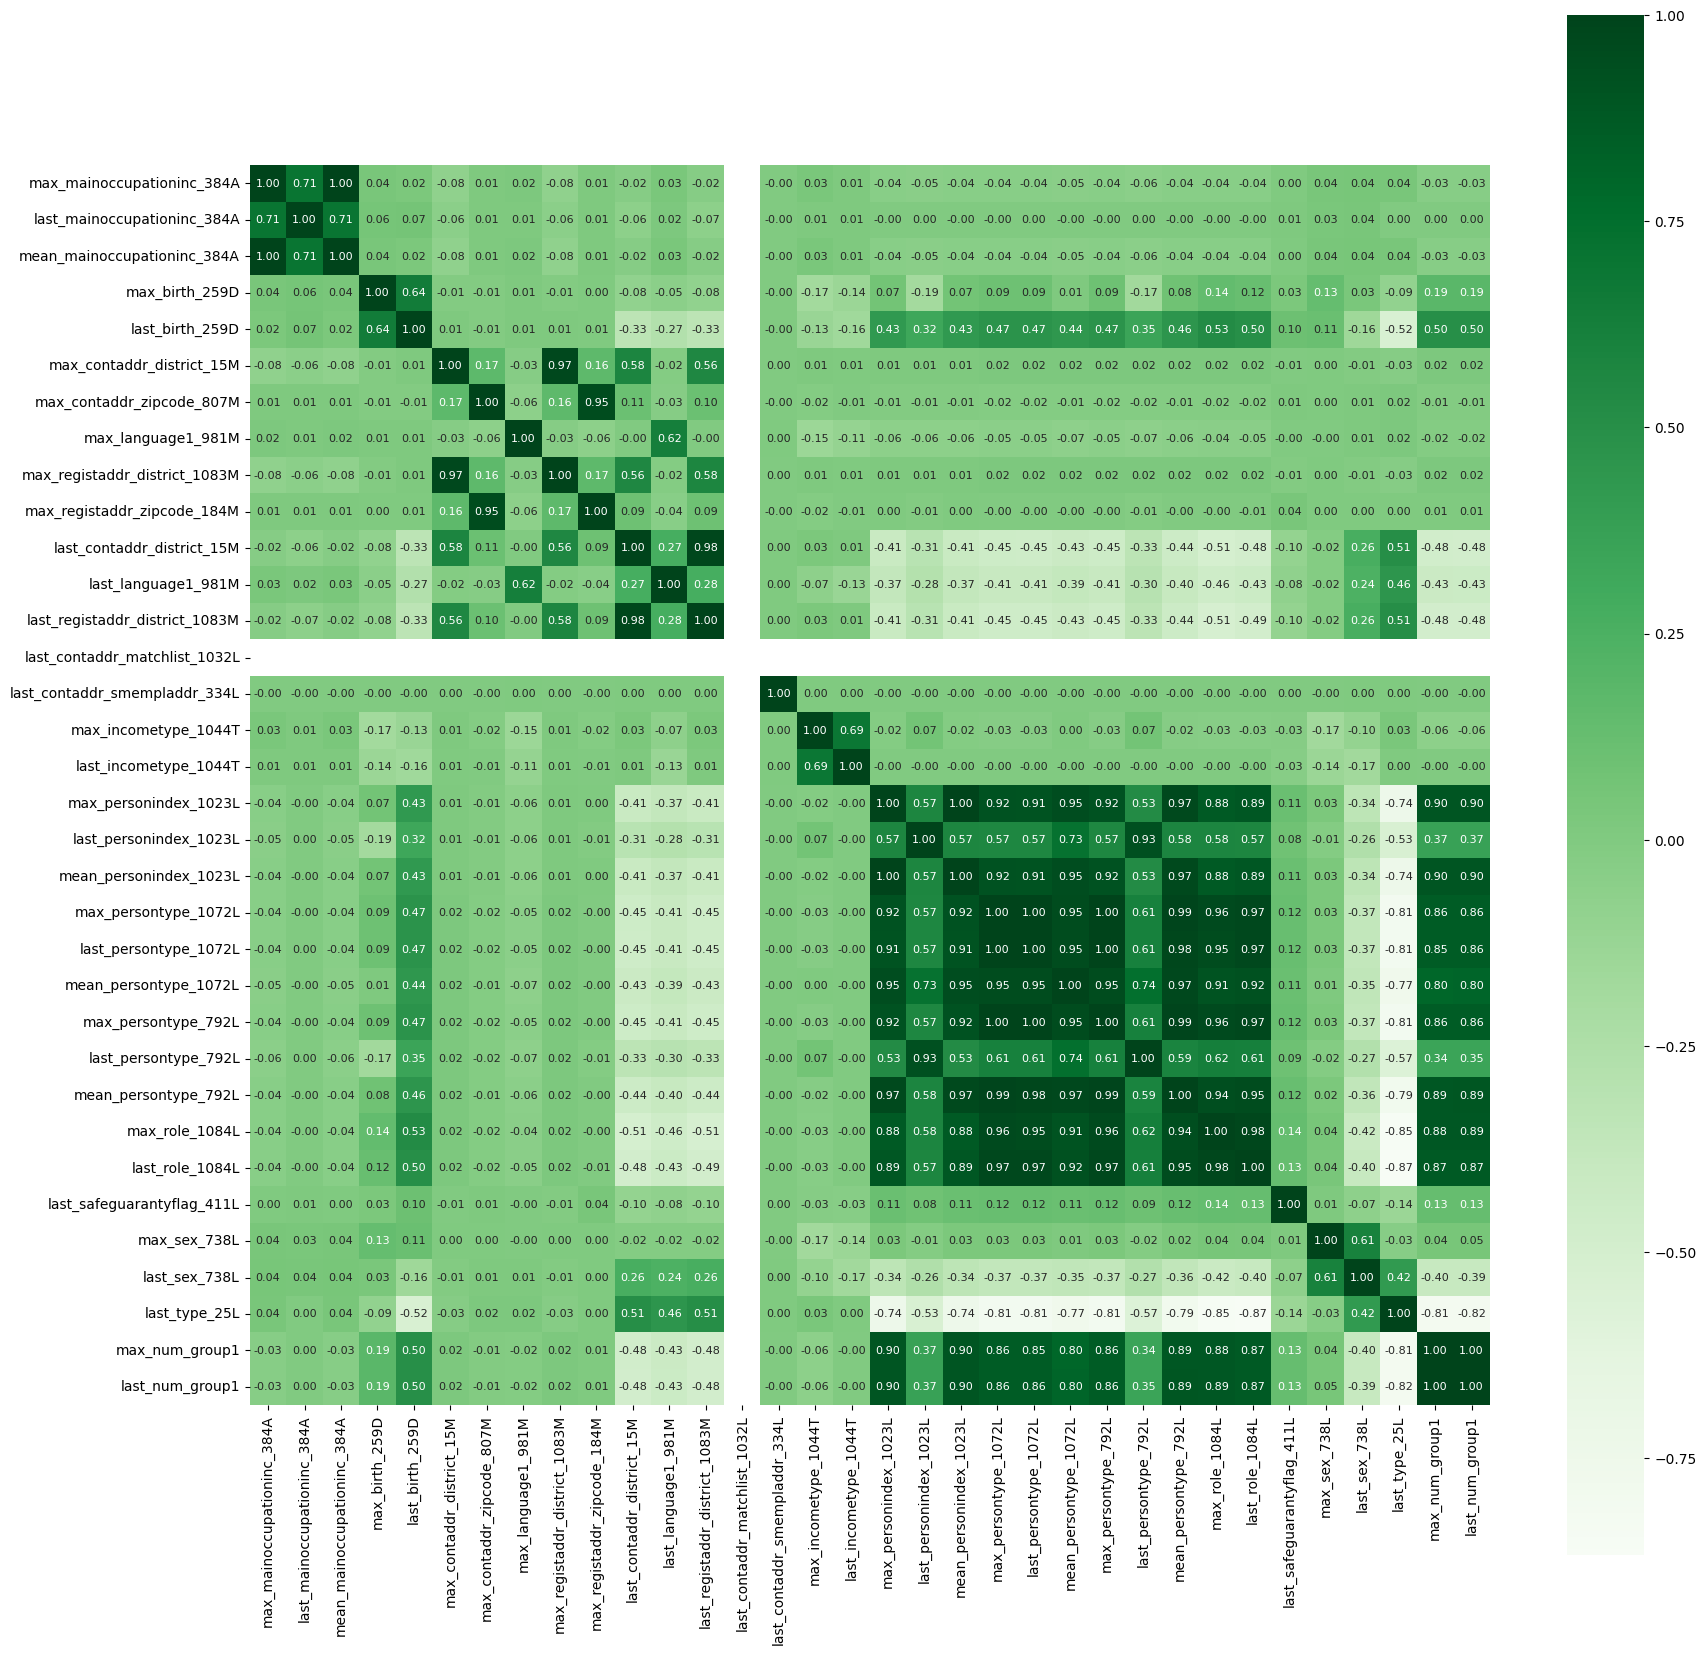

Number of highly correlated features: 
max_mainoccupationinc_384A        1
last_mainoccupationinc_384A       0
mean_mainoccupationinc_384A       1
max_birth_259D                    0
last_birth_259D                   0
max_contaddr_district_15M         1
max_contaddr_zipcode_807M         1
max_language1_981M                0
max_registaddr_district_1083M     1
max_registaddr_zipcode_184M       1
last_contaddr_district_15M        1
last_language1_981M               0
last_registaddr_district_1083M    1
last_contaddr_matchlist_1032L     0
last_contaddr_smempladdr_334L     0
max_incometype_1044T              0
last_incometype_1044T             0
max_personindex_1023L             8
last_personindex_1023L            1
mean_personindex_1023L            8
max_persontype_1072L              8
last_persontype_1072L             8
mean_persontype_1072L             8
max_persontype_792L               8
last_persontype_792L              1
mean_persontype_792L              8
max_role_1084L           

In [20]:
corr_matrix(scaled_x_df)

In [21]:
new_x = scaled_x_df.drop(["max_personindex_1023L", "mean_personindex_1023L", "max_persontype_1072L", "mean_persontype_1072L",
                         "last_persontype_1072L", "max_persontype_792L", "mean_persontype_792L"], axis=1)

new_x.head()

,max_mainoccupationinc_384A,last_mainoccupationinc_384A,mean_mainoccupationinc_384A,max_birth_259D,last_birth_259D,max_contaddr_district_15M,max_contaddr_zipcode_807M,max_language1_981M,max_registaddr_district_1083M,max_registaddr_zipcode_184M,...,last_personindex_1023L,last_persontype_792L,max_role_1084L,last_role_1084L,last_safeguarantyflag_411L,max_sex_738L,last_sex_738L,last_type_25L,max_num_group1,last_num_group1
0,-1.406593,1.555079e-08,-1.406593,0.804932,0.594203,1.586842,-0.598025,-0.826699,1.581922,-0.586886,...,0.000027,-0.000032,1.212339,1.23412,0.15385,-0.776097,-0.469957,-1.025369,1.830553,1.831669
1,-1.430583,1.555079e-08,-1.430583,-1.260414,0.594203,-1.541245,-0.458211,-0.826699,-1.542869,-0.445985,...,0.000027,-0.000032,1.212339,1.23412,0.15385,1.288498,-0.469957,-1.025369,2.722652,2.722317
2,-1.310636,1.555079e-08,-1.310636,-0.022302,0.594203,1.653248,-0.678466,-0.826699,1.650599,-0.667952,...,0.000027,-0.000032,1.212339,1.23412,0.15385,-0.776097,-0.469957,-1.025369,2.722652,2.722317
3,-1.430583,1.555079e-08,-1.430583,1.311050,0.594203,-0.587091,-0.684212,-0.826699,-0.595130,-0.673742,...,0.000027,-0.000032,1.212339,1.23412,0.15385,-0.776097,-0.469957,-1.025369,0.938454,0.941022
4,-1.010771,1.555079e-08,-1.010771,1.340971,0.594203,0.101438,1.459925,-0.826699,0.101939,1.488021,...,0.000027,-0.000032,1.212339,1.23412,0.15385,-0.776097,-0.469957,-1.025369,1.830553,1.831669


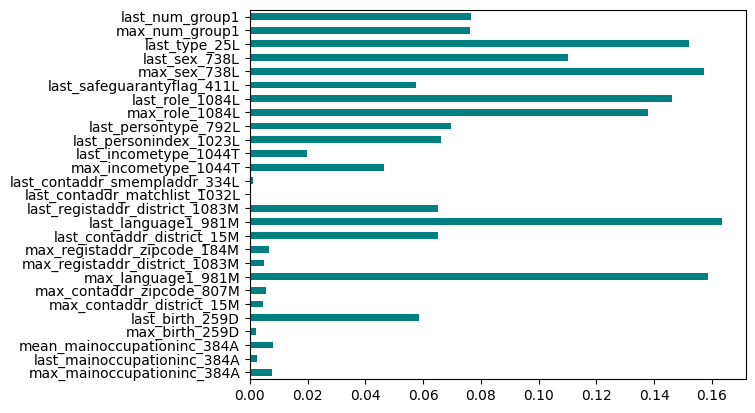

In [22]:
person_1_sel_features = feature_selection_by_information_gain(new_x, person_1_target, 0.1)

In [23]:
print(person_1_sel_features)

['max_language1_981M', 'last_language1_981M', 'max_role_1084L', 'last_role_1084L', 'max_sex_738L', 'last_sex_738L', 'last_type_25L']


# Applprev_2

In [24]:
applprev_2_df = prepare_df(TRAIN_DIR/"train_applprev_2.csv", 2)

Path : /kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_applprev_2.csv
Columns dropped due to more than 50% missing values:
Index(['max_max_cacccardblochreas_147M', 'max_last_cacccardblochreas_147M',
       'last_max_cacccardblochreas_147M', 'last_last_cacccardblochreas_147M',
       'max_max_credacc_cards_status_52L', 'last_max_credacc_cards_status_52L',
       'max_last_credacc_cards_status_52L',
       'last_last_credacc_cards_status_52L'],
      dtype='object')
Shape of cleaned DataFrame: (1221522, 15)


/tmp/ipykernel_18/1874175882.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipykernel_18/1874175882.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

Columns with missing values:


In [25]:
applprev_2_df.head()

,case_id,max_last_conts_type_509L,last_last_conts_type_509L,max_num_group1,max_max_num_group1,max_max_num_group2,max_last_num_group1,max_last_num_group2,last_num_group1,last_max_num_group1,last_max_num_group2,last_last_num_group1,last_last_num_group2
0,1641012,PHONE,PHONE,2,2,1,2,1,0,0,1,0,1
1,895839,HOME_PHONE,HOME_PHONE,1,1,2,1,2,0,0,2,0,2
2,224220,PRIMARY_MOBILE,HOME_PHONE,19,19,3,19,3,3,3,1,3,1
3,2612426,PRIMARY_MOBILE,PRIMARY_MOBILE,1,1,1,1,1,1,1,1,1,1
4,160967,PRIMARY_MOBILE,PRIMARY_MOBILE,19,19,2,19,2,4,4,0,4,0


In [26]:
applprev_2_categorical_cols = get_unique_info_for_categorical_cols(applprev_2_df)

/tmp/ipykernel_18/2024442434.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if col != "case_id" and (pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col])):


max_last_conts_type_509L : 8 unique values
['PHONE', 'HOME_PHONE', 'PRIMARY_MOBILE', 'PRIMARY_EMAIL', 'EMPLOYMENT_PHONE', 'SECONDARY_MOBILE', 'ALTERNATIVE_PHONE', 'WHATSAPP']
last_last_conts_type_509L : 8 unique values
['PHONE', 'HOME_PHONE', 'PRIMARY_MOBILE', 'EMPLOYMENT_PHONE', 'PRIMARY_EMAIL', 'ALTERNATIVE_PHONE', 'SECONDARY_MOBILE', 'WHATSAPP']


In [27]:
encoded_applprev_2_df = ordinal_encoder(applprev_2_df, applprev_2_categorical_cols)
encoded_applprev_2_df.head()

,case_id,max_last_conts_type_509L,last_last_conts_type_509L,max_num_group1,max_max_num_group1,max_max_num_group2,max_last_num_group1,max_last_num_group2,last_num_group1,last_max_num_group1,last_max_num_group2,last_last_num_group1,last_last_num_group2
725021,2,1.0,1.0,1,1,1,1,1,0,0,1,0,1
174964,3,4.0,4.0,0,0,2,0,2,0,0,2,0,2
346591,4,2.0,2.0,0,0,1,0,1,0,0,1,0,1
649163,5,5.0,5.0,0,0,0,0,0,0,0,0,0,0
178647,6,5.0,1.0,2,2,1,2,1,2,2,1,2,1


In [28]:
applprev_2_x, target = match_x_and_target(encoded_applprev_2_df, target_df)
applprev_2_x.head()

,max_last_conts_type_509L,last_last_conts_type_509L,max_num_group1,max_max_num_group1,max_max_num_group2,max_last_num_group1,max_last_num_group2,last_num_group1,last_max_num_group1,last_max_num_group2,last_last_num_group1,last_last_num_group2
0,1.0,1.0,1,1,1,1,1,0,0,1,0,1
1,4.0,4.0,0,0,2,0,2,0,0,2,0,2
2,2.0,2.0,0,0,1,0,1,0,0,1,0,1
3,5.0,5.0,0,0,0,0,0,0,0,0,0,0
4,5.0,1.0,2,2,1,2,1,2,2,1,2,1


In [29]:
scaler = StandardScaler()

scaled_applprev_2_x = scaler.fit_transform(applprev_2_x)

scaled_applprev_2_x_df = pd.DataFrame(scaled_applprev_2_x, columns = applprev_2_x.columns)
scaled_applprev_2_x_df.head()

,max_last_conts_type_509L,last_last_conts_type_509L,max_num_group1,max_max_num_group1,max_max_num_group2,max_last_num_group1,max_last_num_group2,last_num_group1,last_max_num_group1,last_max_num_group2,last_last_num_group1,last_last_num_group2
0,-3.139866,-2.030393,-0.718908,-0.718908,-0.887200,-0.718908,-0.887200,-0.704143,-0.704143,-0.185057,-0.704143,-0.185057
1,-0.431504,0.008520,-0.933989,-0.933989,0.393546,-0.933989,0.393546,-0.704143,-0.704143,1.074459,-0.704143,1.074459
2,-2.237079,-1.350755,-0.933989,-0.933989,-0.887200,-0.933989,-0.887200,-0.704143,-0.704143,-0.185057,-0.704143,-0.185057
3,0.471284,0.688158,-0.933989,-0.933989,-2.167946,-0.933989,-2.167946,-0.704143,-0.704143,-1.444574,-0.704143,-1.444574
4,0.471284,-2.030393,-0.503827,-0.503827,-0.887200,-0.503827,-0.887200,-0.055437,-0.055437,-0.185057,-0.055437,-0.185057


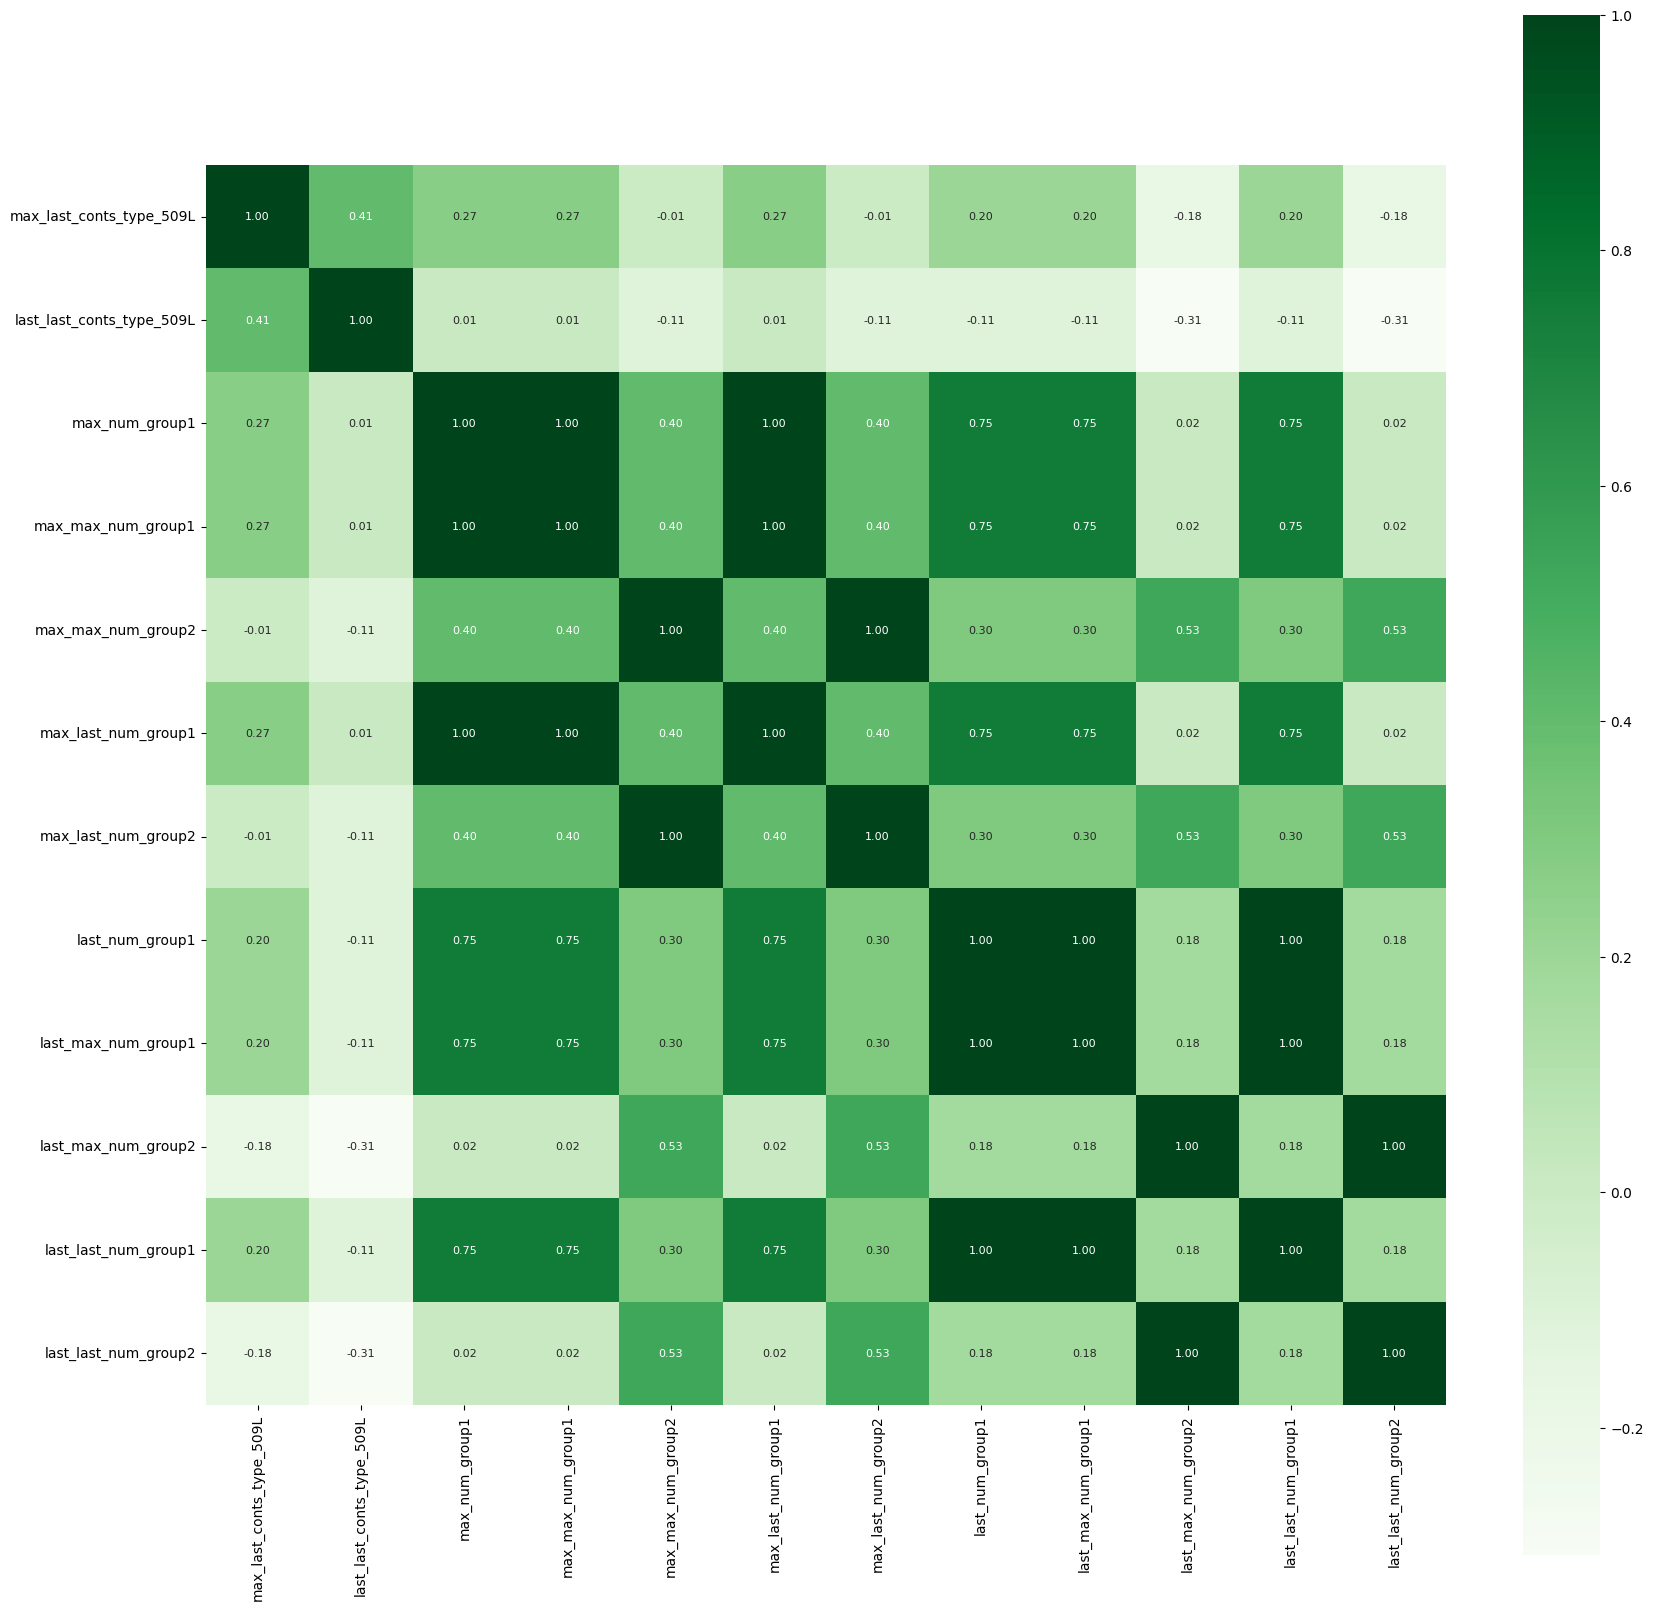

Number of highly correlated features: 
max_last_conts_type_509L     0
last_last_conts_type_509L    0
max_num_group1               2
max_max_num_group1           2
max_max_num_group2           1
max_last_num_group1          2
max_last_num_group2          1
last_num_group1              2
last_max_num_group1          2
last_max_num_group2          1
last_last_num_group1         2
last_last_num_group2         1
dtype: int64


In [30]:
corr_matrix(scaled_applprev_2_x_df)

In [31]:
scaled_applprev_2_x_df

,max_last_conts_type_509L,last_last_conts_type_509L,max_num_group1,max_max_num_group1,max_max_num_group2,max_last_num_group1,max_last_num_group2,last_num_group1,last_max_num_group1,last_max_num_group2,last_last_num_group1,last_last_num_group2
0,-3.139866,-2.030393,-0.718908,-0.718908,-0.887200,-0.718908,-0.887200,-0.704143,-0.704143,-0.185057,-0.704143,-0.185057
1,-0.431504,0.008520,-0.933989,-0.933989,0.393546,-0.933989,0.393546,-0.704143,-0.704143,1.074459,-0.704143,1.074459
2,-2.237079,-1.350755,-0.933989,-0.933989,-0.887200,-0.933989,-0.887200,-0.704143,-0.704143,-0.185057,-0.704143,-0.185057
3,0.471284,0.688158,-0.933989,-0.933989,-2.167946,-0.933989,-2.167946,-0.704143,-0.704143,-1.444574,-0.704143,-1.444574
4,0.471284,-2.030393,-0.503827,-0.503827,-0.887200,-0.503827,-0.887200,-0.055437,-0.055437,-0.185057,-0.055437,-0.185057
...,...,...,...,...,...,...,...,...,...,...,...,...
1221517,0.471284,0.688158,1.646983,1.646983,0.393546,1.646983,0.393546,2.215036,2.215036,-1.444574,2.215036,-1.444574
1221518,0.471284,0.688158,0.141416,0.141416,1.674292,0.141416,1.674292,-0.379790,-0.379790,1.074459,-0.379790,1.074459
1221519,-1.334291,0.688158,-0.503827,-0.503827,-0.887200,-0.503827,-0.887200,-0.704143,-0.704143,-0.185057,-0.704143,-0.185057
1221520,-2.237079,-1.350755,0.786659,0.786659,1.674292,0.786659,1.674292,0.268917,0.268917,-0.185057,0.268917,-0.185057


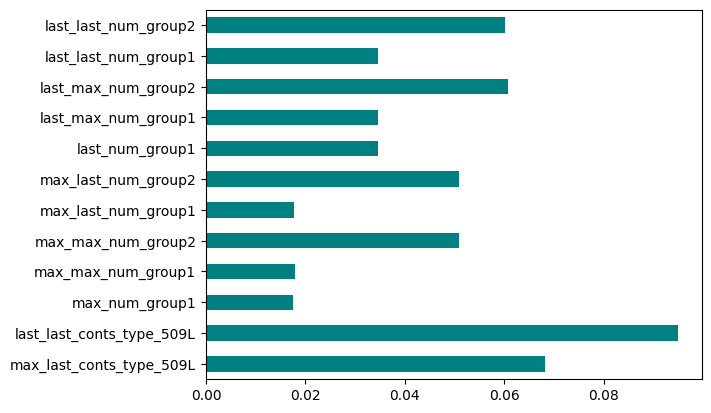

In [32]:
applprev_2_sel_features = feature_selection_by_information_gain(scaled_applprev_2_x_df, target, 0.1)

In [33]:
print(applprev_2_sel_features)

[]


# static_cb_0

In [34]:
static_cb_0_df = prepare_df(TRAIN_DIR/"train_static_cb_0.csv", 0)

Path : /kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_static_cb_0.csv
Columns dropped due to more than 50% missing values:
Index(['assignmentdate_238D', 'assignmentdate_4527235D',
       'assignmentdate_4955616D', 'birthdate_574D', 'contractssum_5085716L',
       'dateofbirth_342D', 'description_5085714M', 'education_1103M',
       'education_88M', 'for3years_128L', 'for3years_504L', 'for3years_584L',
       'formonth_118L', 'formonth_206L', 'formonth_535L', 'forquarter_1017L',
       'forquarter_462L', 'forquarter_634L', 'fortoday_1092L', 'forweek_1077L',
       'forweek_528L', 'forweek_601L', 'foryear_618L', 'foryear_818L',
       'foryear_850L', 'maritalst_893M', 'pmtaverage_3A',
       'pmtaverage_4527227A', 'pmtaverage_4955615A', 'pmtcount_4527229L',
       'pmtcount_4955617L', 'pmtcount_693L', 'pmtscount_423L', 'pmtssum_45A',
       'requesttype_4525192L', 'responsedate_1012D', 'responsedate_4527233D',
       'responsedate_4917613D', 'riskassesment_30

/tmp/ipykernel_18/1874175882.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipykernel_18/1874175882.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

Columns with missing values:


In [35]:
static_cb_0_df.head()

,case_id,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,firstquarter_103L,fourthquarter_440L,maritalst_385M,numberofqueries_373L,secondquarter_766L,thirdquarter_1082L
0,357,583718400000000,1.607422,2.388672,0.517578,4.777344,1.210938,2.861328,2.851562,3439d993,4.777344,2.689453,2.917969
1,381,583718400000000,1.607422,2.388672,0.517578,4.777344,1.210938,2.861328,2.851562,3439d993,4.777344,2.689453,2.917969
2,388,607392000000000,6.000000,8.000000,2.000000,10.000000,4.000000,2.000000,6.000000,3439d993,10.000000,3.000000,5.000000
3,405,131328000000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,3439d993,1.000000,2.000000,0.000000
4,409,738892800000000,2.000000,3.000000,0.000000,3.000000,1.000000,4.000000,1.000000,a7fcb6e5,3.000000,0.000000,4.000000


In [36]:
static_cb_0_categorical_cols = get_unique_info_for_categorical_cols(static_cb_0_df)
print(static_cb_0_categorical_cols)

maritalst_385M : 5 unique values
['3439d993', 'a7fcb6e5', 'b6cabe76', '38c061ee', 'ecd83604']
['maritalst_385M']


/tmp/ipykernel_18/2024442434.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if col != "case_id" and (pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col])):


In [37]:
encoded_static_cb_0_df = ordinal_encoder(static_cb_0_df, static_cb_0_categorical_cols)
encoded_static_cb_0_df.head()

,case_id,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,firstquarter_103L,fourthquarter_440L,maritalst_385M,numberofqueries_373L,secondquarter_766L,thirdquarter_1082L
0,357,583718400000000,1.607422,2.388672,0.517578,4.777344,1.210938,2.861328,2.851562,0.0,4.777344,2.689453,2.917969
1,381,583718400000000,1.607422,2.388672,0.517578,4.777344,1.210938,2.861328,2.851562,0.0,4.777344,2.689453,2.917969
2,388,607392000000000,6.000000,8.000000,2.000000,10.000000,4.000000,2.000000,6.000000,0.0,10.000000,3.000000,5.000000
3,405,131328000000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,0.0,1.000000,2.000000,0.000000
4,409,738892800000000,2.000000,3.000000,0.000000,3.000000,1.000000,4.000000,1.000000,2.0,3.000000,0.000000,4.000000


In [38]:
static_cb_0_x, static_cb_0_target = match_x_and_target(encoded_static_cb_0_df, target_df)
static_cb_0_x.head()

,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,firstquarter_103L,fourthquarter_440L,maritalst_385M,numberofqueries_373L,secondquarter_766L,thirdquarter_1082L
0,583718400000000,1.607422,2.388672,0.517578,4.777344,1.210938,2.861328,2.851562,0.0,4.777344,2.689453,2.917969
1,583718400000000,1.607422,2.388672,0.517578,4.777344,1.210938,2.861328,2.851562,0.0,4.777344,2.689453,2.917969
2,607392000000000,6.000000,8.000000,2.000000,10.000000,4.000000,2.000000,6.000000,0.0,10.000000,3.000000,5.000000
3,131328000000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,0.0,1.000000,2.000000,0.000000
4,738892800000000,2.000000,3.000000,0.000000,3.000000,1.000000,4.000000,1.000000,2.0,3.000000,0.000000,4.000000


In [39]:
scaler = StandardScaler()

scaled_static_cb_0_x = scaler.fit_transform(static_cb_0_x)

scaled_static_cb_0_x_df = pd.DataFrame(scaled_static_cb_0_x, columns = static_cb_0_x.columns)
scaled_static_cb_0_x_df.head()

,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,firstquarter_103L,fourthquarter_440L,maritalst_385M,numberofqueries_373L,secondquarter_766L,thirdquarter_1082L
0,0.891771,-0.000135,0.000005,-0.000139,0.000052,-0.000280,0.000196,0.000098,-0.467143,0.000052,0.000281,-0.000105
1,0.891771,-0.000135,0.000005,-0.000139,0.000052,-0.000280,0.000196,0.000098,-0.467143,0.000052,0.000281,-0.000105
2,0.946428,2.194241,2.019682,1.715314,1.051477,1.752379,-0.248018,0.954812,-0.467143,1.051477,0.097483,0.632675
3,-0.152693,-0.803146,-0.859746,-0.599078,-0.760404,-0.761238,-0.824370,0.348343,-0.467143,-0.760404,-0.215520,-0.886946
4,1.250033,0.195983,0.220040,-0.599078,-0.357763,-0.132834,0.328335,-0.561359,1.809959,-0.357763,-0.841527,0.328751


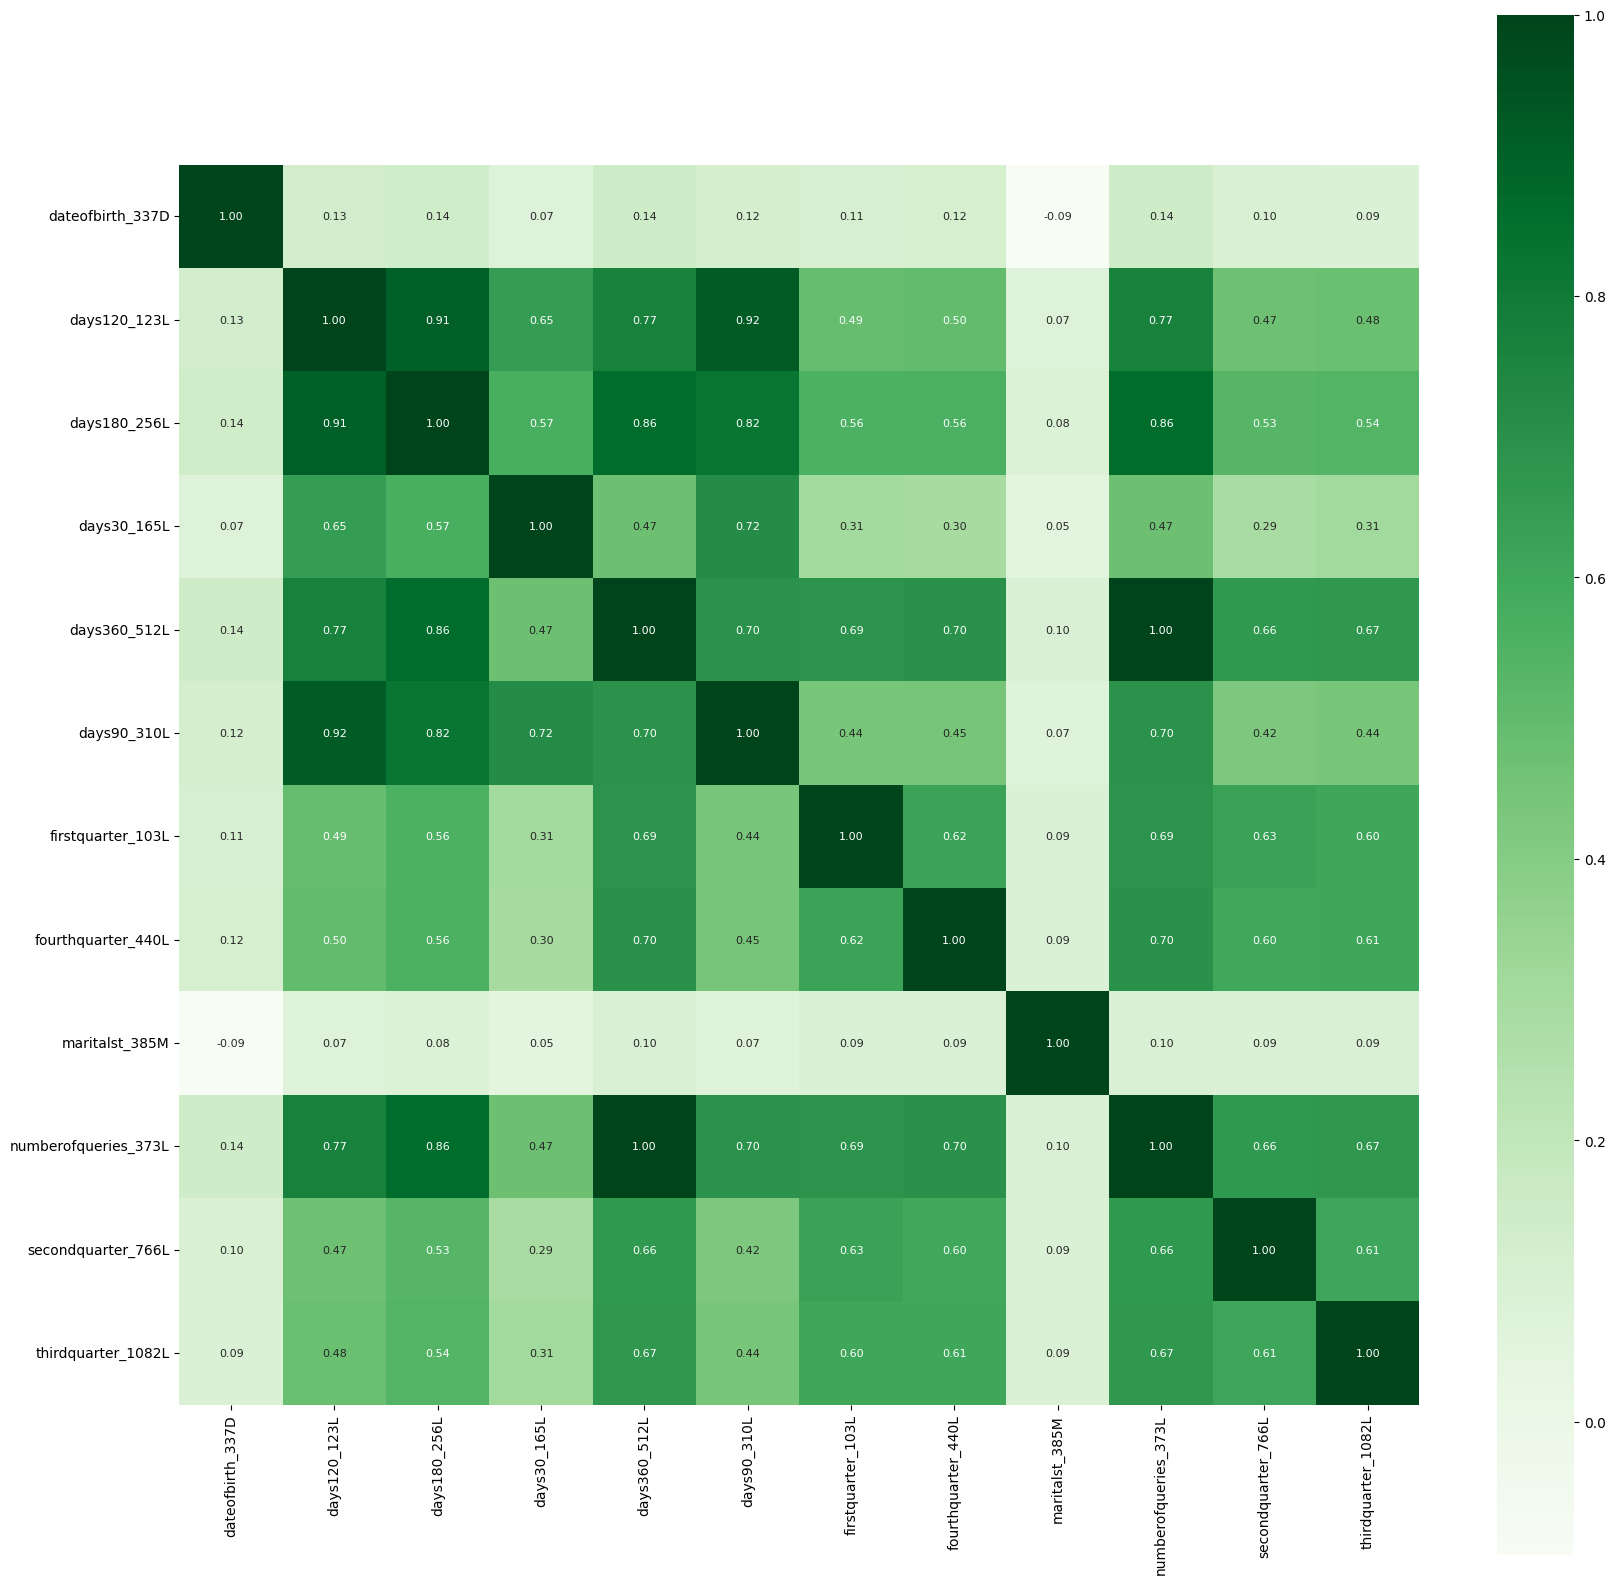

Number of highly correlated features: 
dateofbirth_337D        0
days120_123L            2
days180_256L            1
days30_165L             0
days360_512L            1
days90_310L             1
firstquarter_103L       0
fourthquarter_440L      0
maritalst_385M          0
numberofqueries_373L    1
secondquarter_766L      0
thirdquarter_1082L      0
dtype: int64


In [40]:
corr_matrix(scaled_static_cb_0_x_df)

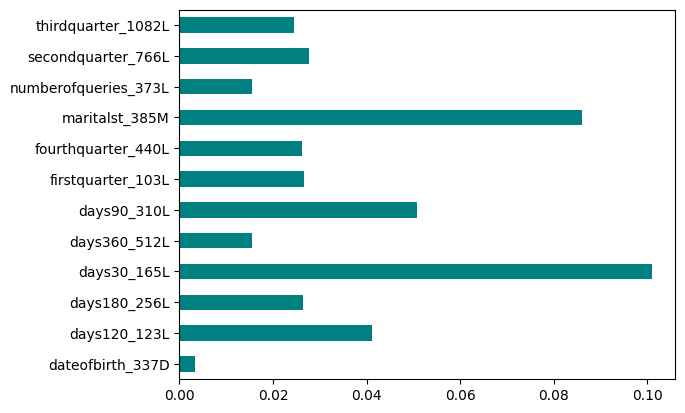

In [41]:
static_cb_0_sel_features = feature_selection_by_information_gain(scaled_static_cb_0_x_df, static_cb_0_target, 0.1)

In [42]:
static_cb_0_sel_features

['days30_165L']